# Kurdish Full Alphabet OCR - Advanced Training Pipeline

## Project Overview
This notebook implements a state-of-the-art **Deep Residual Network (ResNet-style CNN)** to classify the full Kurdish alphabet (35 letters + digits). Unlike basic CNNs, this model uses **residual connections** and **projection shortcuts**, allowing it to learn deeper features without the vanishing gradient problem.

## Key Features
* **Architecture:** Custom ResNet with 4 Residual Blocks & Projection Layers.
* **Performance:** Optimized for **95%+ Accuracy** on complex handwritten datasets.
* **Speed:** Uses **Mixed Precision (AMP)** for faster training on GPUs.
* **Safety:** Includes a **Generalization Monitor** to detect and stop overfitting early.

## Pipeline Steps
1.  **Data Loading:** Imports images and applies Augmentation (Rotation, Noise, Elastic Transform).
2.  **Model Definition:** Builds the `KurdishAdvancedCNN` with 1x1 projection shortcuts.
3.  **Training:** Runs the optimized training loop with dynamic learning rate adjustment.
4.  **Evaluation:** Saves the best model (`.pth`) and the Label Encoder (`.pkl`) for deployment.

## Libraries required

In [7]:
import os                                    # File and directory operations
import sys                                   # System-specific parameters and functions
import subprocess                            # Subprocess management
import cv2                                   # OpenCV - Image reading, resizing, processing
import numpy as np                           # NumPy - Array operations and numerical computing
import torch                                 # PyTorch - Deep learning framework
import torch.nn as nn                        # PyTorch neural network modules
import torch.optim as optim                  # PyTorch optimization algorithms (Adam, SGD, etc.)
from torch.utils.data import DataLoader, Dataset, TensorDataset  # Data loading utilities
from sklearn.model_selection import train_test_split    # Train/test data splitting
from sklearn.preprocessing import LabelEncoder          # Categorical label encoding
from sklearn.metrics import accuracy_score, classification_report  # Model evaluation metrics
from sklearn.model_selection import StratifiedKFold     # Cross-validation

# Install albumentations if not available
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    print("Albumentations loaded successfully!")
except ImportError:
    print("Installing albumentations...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "albumentations"])
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    print("Albumentations installed and loaded successfully!")
    
import glob                                  # File pattern matching
import pickle                                # For saving label encoders
from PIL import Image                        # Alternative image loading
from tqdm import tqdm                        # Progress bars
import random                                # For reproducibility
import time                                  # Time measurements

print("All libraries loaded successfully!")

Albumentations loaded successfully!
All libraries loaded successfully!


## Model Architecture: Advanced ResNet-CNN
We are using a custom Residual Network designed for 64x64 character recognition.

### Why not a simple CNN?
Simple CNNs struggle with deep hierarchies. By adding **Residual Connections** (`x + residual`), we allow the model to learn "corrections" to the identity function, which dramatically improves convergence and accuracy.

### The Structure
1.  **Input:** 64x64 images (3 Channels).
2.  **4 Residual Blocks:**
    * Each block has 2 Convolutional layers + Batch Norm + LeakyReLU.
    * **Projection Layer:** If channel dimensions change (e.g., 32 to 64), a 1x1 Convolution adjusts the residual size to match.
3.  **Global Average Pooling:** Instead of `Flatten()`, we use Adaptive Pooling. This makes the model robust to slightly different input sizes and reduces parameter count.
4.  **Classification Head:** Dense layers with Dropout (40%) to predict the final class.

In [9]:
IMG_SIZE = 64
CHANNELS = 1
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 15
DATA_DIR = "combined_dataset"  # Directory with combined data
MODEL_PATH = "kurdish_letter_model_pytorch.pth"
LABEL_ENCODER_PATH = "label_encoder.pkl"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

EXTENSIONS = [".png", ".jpg", ".jpeg", ".bmp"]

# Data augmentation transforms
train_transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.Rotate(limit=15, p=0.3),
    A.Affine(translate_percent=0.1, scale=(0.9, 1.1), rotate=(-10, 10), p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),  # Using var_limit as it's still valid in some versions
    A.ElasticTransform(alpha=1, sigma=50, p=0.1),
    A.Normalize(mean=[0.456], std=[0.224]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=[0.456], std=[0.224]),
    ToTensorV2()
])

Using device: cuda


/tmp/ipykernel_640129/415495028.py:22: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),  # Using var_limit as it's still valid in some versions


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class KurdishAdvancedCNN(nn.Module):
    """
    Upgraded CNN with Projection Shortcuts (Fixes Dimension Mismatch),
    LeakyReLU (Prevents dead neurons), and Global Pooling (Fixes input size crash).
    """
    def __init__(self, num_classes, dropout_rate=0.3):
        super(KurdishAdvancedCNN, self).__init__()
        
        # --- BLOCK 1: Input -> 32 channels ---
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(dropout_rate)
        
        # --- BLOCK 2: 32 -> 64 channels ---
        # Projection Layer: 1x1 Conv to resize 32 -> 64 for residual addition
        self.project2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64)
        )
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        
        # --- BLOCK 3: 64 -> 128 channels ---
        # Projection Layer: 64 -> 128
        self.project3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, bias=False),
            nn.BatchNorm2d(128)
        )
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(dropout_rate)
        
        # --- BLOCK 4: 128 -> 256 channels ---
        # Projection Layer: 128 -> 256
        self.project4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256)
        )
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout2d(dropout_rate)
        
        # --- HEAD ---
        # Global Average Pooling: Handles any image size (4x4, 8x8, etc.)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(256, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, num_classes)
        
        self.dropout_fc = nn.Dropout(dropout_rate)
        self.leaky_relu = nn.LeakyReLU(0.1) # Better gradient flow

    def forward(self, x):
        # Block 1
        x = self.leaky_relu(self.bn1(self.conv1(x)))
        residual = x
        x = self.leaky_relu(self.bn2(self.conv2(x)))
        x = self.leaky_relu(x + residual)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        residual = self.project2(x) # Resize residual
        x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = self.bn4(self.conv4(x))
        x = self.leaky_relu(x + residual)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Block 3
        residual = self.project3(x) # Resize residual
        x = self.leaky_relu(self.bn5(self.conv5(x)))
        x = self.bn6(self.conv6(x))
        x = self.leaky_relu(x + residual)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Block 4
        residual = self.project4(x) # Resize residual
        x = self.leaky_relu(self.bn7(self.conv7(x)))
        x = self.bn8(self.conv8(x))
        x = self.leaky_relu(x + residual)
        x = self.pool4(x)
        x = self.dropout4(x)
        
        # Classifier
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        x = self.leaky_relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc(x)
        x = self.leaky_relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc(x)
        x = self.fc3(x)
        
        return x

## Custom Dataset Class

Loads and preprocesses all images from the combined letter category folders.

**Process:**
1. Scans all letter folders in the dataset directory
2. Reads images in supported formats (PNG, JPG, JPEG, BMP)
3. Converts to grayscale
4. Resizes to 64x64 pixels
5. Applies data augmentation during training
6. Stores image arrays and corresponding labels

**Output:**
- `images`: List of file paths
- `labels`: Corresponding class labels
- Total images loaded across all categories

In [11]:
class KurdishAlphabetDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.images = []
        self.labels = []
        
        print(f"Loading data from {dataset_path}...")
        
        # Get all class folders
        class_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
        
        # Create label encoder
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(class_folders)
        
        # Load images and labels
        for class_folder in class_folders:
            class_folder_path = os.path.join(dataset_path, class_folder)
            class_label = self.label_encoder.transform([class_folder])[0]
            
            image_files = []
            for ext in EXTENSIONS:
                image_files.extend(glob.glob(os.path.join(class_folder_path, f"*{ext}")))
                image_files.extend(glob.glob(os.path.join(class_folder_path, f"*{ext.upper()}")))
            
            for img_file in image_files:
                self.images.append(img_file)
                self.labels.append(class_label)
        
        print(f"Loaded {len(self.images)} images from {len(class_folders)} classes")
        print(f"Classes: {self.label_encoder.classes_}")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Load image
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            # Fallback to PIL if OpenCV fails
            image = np.array(Image.open(img_path).convert('L'))
        
        # Resize if needed
        if image.shape != (IMG_SIZE, IMG_SIZE):
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        
        # Convert grayscale to 3-channel for albumentations
        image = np.stack([image] * 3, axis=-1)
        
        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        else:
            # Convert to tensor without augmentation
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
        
        return image, label

## Optimized Training Loop
This is a production-grade training routine designed for stability and speed.

### Features
* **Mixed Precision (AMP):** Uses `float16` for calculations and `float32` for weight updates. This reduces memory usage and speeds up training.
* **Generalization Monitor:** Calculates the "Delta" (Gap) between Training Loss and Validation Loss.
    * If `Val Loss > Train Loss + 0.5`, it warns of overfitting.
    * If this persists for 5 epochs, training stops to prevent "memorization."
* **Smart Scheduler:** If the Validation Loss stops improving, the Learning Rate is automatically cut in half.
* **Checkpointing:** The model is saved **only** when Validation Accuracy improves.

In [12]:
# --- DATA PREPARATION ---
# Load the dataset
if not os.path.exists(DATA_DIR):
    print(f"Warning: Data directory '{DATA_DIR}' does not exist.")
    print("Please run the dataset combination script first or update DATA_DIR.")
    # Use a sample dataset structure as fallback
    DATA_DIR = os.path.join(os.getcwd(), "Custom Dataset")
    print(f"Using fallback directory: {DATA_DIR}")

kurdish_dataset = KurdishAlphabetDataset(DATA_DIR, transform=train_transform)

if len(kurdish_dataset) == 0:
    print("No images loaded. Exiting.")
    exit()

# Split dataset into train and validation
dataset_size = len(kurdish_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    kurdish_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create custom validation dataset with different transform
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        # Apply validation transform
        if self.transform:
            # Convert tensor back to numpy for albumentations, then back to tensor
            x_np = x.numpy().transpose(1, 2, 0)  # Convert from CHW to HWC
            x_np = (x_np * 0.224 + 0.456) * 255  # Reverse normalization
            x_np = x_np.astype(np.uint8)
            
            # Apply validation transforms
            augmented = self.transform(image=x_np)
            x = augmented['image']
        return x, y
        
    def __len__(self):
        return len(self.subset)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of classes: {len(kurdish_dataset.label_encoder.classes_)}")

# --- MODEL INITIALIZATION ---
num_classes = len(kurdish_dataset.label_encoder.classes_)
model = KurdishAdvancedCNN(num_classes=num_classes, dropout_rate=0.3).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

print(f"\nModel initialized with {num_classes} output classes")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Loading data from combined_dataset...
Loaded 33067 images from 33 classes
Classes: ['ا\u200e' 'ب\u200e' 'ت' 'ج' 'ح' 'خ' 'د\u200e' 'ر\u200e' 'ز\u200e' 'س' 'ش'
 'ع' 'غ' 'ف' 'ق' 'ك' 'ل\u200e' 'م' 'ن' 'ه' 'و' 'وو' 'پ' 'چ\u200e' 'ڕ'
 'ژ\u200e' 'ڤ' 'ک' 'گ' 'ڵ\u200e' 'ھ' 'ۆ' 'ی\u200e']
Training samples: 26453
Validation samples: 6614
Number of classes: 33

Model initialized with 33 output classes
Total parameters: 1491009
Trainable parameters: 1491009


## Training & Evaluation

Trains the CNN model on the training dataset and evaluates performance.

**Training Process:**
1. Creates and initializes the model
2. Sets up loss function (CrossEntropyLoss) and optimizer (Adam)
3. For each epoch:
   - Forward pass through model
   - Calculate loss on training batch
   - Backward pass (backpropagation)
   - Update weights via gradient descent
   - Track training loss and accuracy
4. Evaluates model on validation set (20% of data)
5. Applies learning rate scheduling
6. Implements early stopping to prevent overfitting
7. Saves trained model weights to file

**Metrics:**
- Displays loss and accuracy per epoch
- Final validation accuracy on unseen data
- Model saved as `kurdish_full_alphabet_model_pytorch.pth`

In [6]:
# --- OPTIMIZED TRAINING LOOP (Fixed Warnings) ---
from torch.cuda.amp import GradScaler # Keep this for scaling
import time

print("\nStarting Training with Generalization Monitor...")

# Configuration
max_loss_delta = 0.5    # Alert if Val Loss is >0.5 higher than Train Loss
best_accuracy = 0.0
best_epoch = 0
patience_counter = 0
overfit_counter = 0     # Counts how many times model drifted apart

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize GradScaler for AMP (Speed Optimization)
scaler = GradScaler()

start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start = time.time()
    
    # --- TRAINING PHASE ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # FIX: Use 'torch.amp.autocast' instead of 'torch.cuda.amp.autocast'
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        # Scaled Backward Pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        train_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
    
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train
    
    # --- VALIDATION PHASE ---
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_acc = 100 * correct_val / total_val
    
    # --- GENERALIZATION MONITOR ---
    # Calculate gap between Validation and Training Loss
    loss_delta = epoch_val_loss - epoch_train_loss
    
    # Update Scheduler (Monitors Validation Loss for stability)
    scheduler.step(epoch_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store history
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accuracies.append(epoch_train_acc)
    val_accuracies.append(epoch_val_acc)
    
    # --- REPORTING ---
    time_elapsed = time.time() - epoch_start
    print(f'-' * 80)
    print(f'Epoch [{epoch+1}/{EPOCHS}] | Time: {time_elapsed:.0f}s | LR: {current_lr:.6f}')
    print(f'Train Loss: {epoch_train_loss:.4f}  | Val Loss:  {epoch_val_loss:.4f}  | Delta: {loss_delta:+.4f}')
    print(f'Train Acc:  {epoch_train_acc:.2f}%  | Val Acc:   {epoch_val_acc:.2f}%')
    
    # --- MONITOR LOGIC ---
    if loss_delta > max_loss_delta:
        print(f"⚠️ WARNING: Overfitting detected: Val Loss is {loss_delta:.4f} higher than Train Loss.")
        overfit_counter += 1
    else:
        overfit_counter = 0 # Reset if gap closes
        
    if overfit_counter >= 5:
        print("STOPPING EARLY: Model has been overfitting for 5 consecutive epochs.")
        break

    # --- SAVE BEST MODEL ---
    if epoch_val_acc > best_accuracy:
        best_accuracy = epoch_val_acc
        best_epoch = epoch
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': best_accuracy,
            'label_encoder': kurdish_dataset.label_encoder
        }, MODEL_PATH)
        
        # Save label encoder pickle as well
        with open(LABEL_ENCODER_PATH, 'wb') as f:
            pickle.dump(kurdish_dataset.label_encoder, f)
            
        print(f'New Best Model Saved: Accuracy: {best_accuracy:.2f}%')
    else:
        patience_counter += 1
        
    # Standard Early Stopping (Accuracy based)
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f' Early stopping triggered after {EARLY_STOPPING_PATIENCE} epochs without accuracy improvement')
        break

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/60:.1f} minutes.")
print(f"Best validation accuracy: {best_accuracy:.2f}% at epoch {best_epoch+1}")

/tmp/ipykernel_228942/3683363752.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Starting Training with Generalization Monitor...


Epoch 1/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 55.76it/s, Loss=2.3902]


--------------------------------------------------------------------------------
Epoch [1/100] | Time: 18s | LR: 0.001000
Train Loss: 3.1713  | Val Loss:  2.6282  | Delta: -0.5431
Train Acc:  10.09%  | Val Acc:   21.23%
✅ NEW BEST MODEL SAVED! Accuracy: 21.23%


Epoch 2/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 55.20it/s, Loss=2.2518]


--------------------------------------------------------------------------------
Epoch [2/100] | Time: 19s | LR: 0.001000
Train Loss: 2.4596  | Val Loss:  1.8455  | Delta: -0.6140
Train Acc:  26.84%  | Val Acc:   43.35%
✅ NEW BEST MODEL SAVED! Accuracy: 43.35%


Epoch 3/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.84it/s, Loss=1.3685]


--------------------------------------------------------------------------------
Epoch [3/100] | Time: 18s | LR: 0.001000
Train Loss: 1.6580  | Val Loss:  0.9737  | Delta: -0.6844
Train Acc:  48.74%  | Val Acc:   67.70%
✅ NEW BEST MODEL SAVED! Accuracy: 67.70%


Epoch 4/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.97it/s, Loss=1.0536]


--------------------------------------------------------------------------------
Epoch [4/100] | Time: 18s | LR: 0.001000
Train Loss: 1.0412  | Val Loss:  0.5793  | Delta: -0.4619
Train Acc:  67.64%  | Val Acc:   81.83%
✅ NEW BEST MODEL SAVED! Accuracy: 81.83%


Epoch 5/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.59it/s, Loss=0.5999]


--------------------------------------------------------------------------------
Epoch [5/100] | Time: 18s | LR: 0.001000
Train Loss: 0.7771  | Val Loss:  0.3821  | Delta: -0.3950
Train Acc:  75.60%  | Val Acc:   88.13%
✅ NEW BEST MODEL SAVED! Accuracy: 88.13%


Epoch 6/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.56it/s, Loss=0.6355]


--------------------------------------------------------------------------------
Epoch [6/100] | Time: 18s | LR: 0.001000
Train Loss: 0.6376  | Val Loss:  0.3978  | Delta: -0.2398
Train Acc:  80.16%  | Val Acc:   87.60%


Epoch 7/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.56it/s, Loss=0.4149]


--------------------------------------------------------------------------------
Epoch [7/100] | Time: 18s | LR: 0.000500
Train Loss: 0.5699  | Val Loss:  0.3392  | Delta: -0.2307
Train Acc:  82.55%  | Val Acc:   88.93%
✅ NEW BEST MODEL SAVED! Accuracy: 88.93%


Epoch 8/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.90it/s, Loss=0.6017]


--------------------------------------------------------------------------------
Epoch [8/100] | Time: 18s | LR: 0.000500
Train Loss: 0.4615  | Val Loss:  0.2571  | Delta: -0.2043
Train Acc:  85.91%  | Val Acc:   91.64%
✅ NEW BEST MODEL SAVED! Accuracy: 91.64%


Epoch 9/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 58.28it/s, Loss=0.6744]


--------------------------------------------------------------------------------
Epoch [9/100] | Time: 18s | LR: 0.000500
Train Loss: 0.4100  | Val Loss:  0.2268  | Delta: -0.1832
Train Acc:  87.42%  | Val Acc:   92.52%
✅ NEW BEST MODEL SAVED! Accuracy: 92.52%


Epoch 10/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.56it/s, Loss=0.3191]


--------------------------------------------------------------------------------
Epoch [10/100] | Time: 19s | LR: 0.000500
Train Loss: 0.3905  | Val Loss:  0.2233  | Delta: -0.1671
Train Acc:  87.89%  | Val Acc:   92.88%
✅ NEW BEST MODEL SAVED! Accuracy: 92.88%


Epoch 11/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 58.75it/s, Loss=0.3320]


--------------------------------------------------------------------------------
Epoch [11/100] | Time: 18s | LR: 0.000500
Train Loss: 0.3788  | Val Loss:  0.2135  | Delta: -0.1653
Train Acc:  88.53%  | Val Acc:   93.27%
✅ NEW BEST MODEL SAVED! Accuracy: 93.27%


Epoch 12/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.21it/s, Loss=0.3778]


--------------------------------------------------------------------------------
Epoch [12/100] | Time: 18s | LR: 0.000500
Train Loss: 0.3636  | Val Loss:  0.2009  | Delta: -0.1627
Train Acc:  88.82%  | Val Acc:   93.71%
✅ NEW BEST MODEL SAVED! Accuracy: 93.71%


Epoch 13/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.87it/s, Loss=0.3025]


--------------------------------------------------------------------------------
Epoch [13/100] | Time: 18s | LR: 0.000250
Train Loss: 0.3534  | Val Loss:  0.1961  | Delta: -0.1573
Train Acc:  89.21%  | Val Acc:   93.63%


Epoch 14/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.74it/s, Loss=0.6922]


--------------------------------------------------------------------------------
Epoch [14/100] | Time: 18s | LR: 0.000250
Train Loss: 0.3106  | Val Loss:  0.1747  | Delta: -0.1360
Train Acc:  90.62%  | Val Acc:   94.41%
✅ NEW BEST MODEL SAVED! Accuracy: 94.41%


Epoch 15/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 55.96it/s, Loss=0.1191]


--------------------------------------------------------------------------------
Epoch [15/100] | Time: 18s | LR: 0.000250
Train Loss: 0.2920  | Val Loss:  0.1691  | Delta: -0.1229
Train Acc:  91.23%  | Val Acc:   94.65%
✅ NEW BEST MODEL SAVED! Accuracy: 94.65%


Epoch 16/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 55.73it/s, Loss=0.1863]


--------------------------------------------------------------------------------
Epoch [16/100] | Time: 18s | LR: 0.000250
Train Loss: 0.2882  | Val Loss:  0.1685  | Delta: -0.1197
Train Acc:  91.29%  | Val Acc:   94.50%


Epoch 17/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.02it/s, Loss=0.2759]


--------------------------------------------------------------------------------
Epoch [17/100] | Time: 18s | LR: 0.000250
Train Loss: 0.2825  | Val Loss:  0.1629  | Delta: -0.1196
Train Acc:  91.47%  | Val Acc:   94.83%
✅ NEW BEST MODEL SAVED! Accuracy: 94.83%


Epoch 18/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.53it/s, Loss=0.0677]


--------------------------------------------------------------------------------
Epoch [18/100] | Time: 18s | LR: 0.000250
Train Loss: 0.2642  | Val Loss:  0.1625  | Delta: -0.1017
Train Acc:  92.04%  | Val Acc:   94.57%


Epoch 19/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.53it/s, Loss=0.1327]


--------------------------------------------------------------------------------
Epoch [19/100] | Time: 18s | LR: 0.000125
Train Loss: 0.2649  | Val Loss:  0.1629  | Delta: -0.1020
Train Acc:  92.11%  | Val Acc:   94.90%
✅ NEW BEST MODEL SAVED! Accuracy: 94.90%


Epoch 20/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.62it/s, Loss=0.3868]


--------------------------------------------------------------------------------
Epoch [20/100] | Time: 18s | LR: 0.000125
Train Loss: 0.2457  | Val Loss:  0.1519  | Delta: -0.0938
Train Acc:  92.62%  | Val Acc:   94.86%


Epoch 21/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 58.66it/s, Loss=0.3635]


--------------------------------------------------------------------------------
Epoch [21/100] | Time: 18s | LR: 0.000125
Train Loss: 0.2414  | Val Loss:  0.1489  | Delta: -0.0924
Train Acc:  92.71%  | Val Acc:   95.19%
✅ NEW BEST MODEL SAVED! Accuracy: 95.19%


Epoch 22/100 [Train]: 100%|██████████| 827/827 [00:15<00:00, 54.48it/s, Loss=0.0740]


--------------------------------------------------------------------------------
Epoch [22/100] | Time: 19s | LR: 0.000125
Train Loss: 0.2404  | Val Loss:  0.1471  | Delta: -0.0932
Train Acc:  92.82%  | Val Acc:   95.30%
✅ NEW BEST MODEL SAVED! Accuracy: 95.30%


Epoch 23/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 55.76it/s, Loss=0.3307]


--------------------------------------------------------------------------------
Epoch [23/100] | Time: 18s | LR: 0.000125
Train Loss: 0.2269  | Val Loss:  0.1432  | Delta: -0.0837
Train Acc:  93.18%  | Val Acc:   95.36%
✅ NEW BEST MODEL SAVED! Accuracy: 95.36%


Epoch 24/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.31it/s, Loss=0.0821]


--------------------------------------------------------------------------------
Epoch [24/100] | Time: 18s | LR: 0.000125
Train Loss: 0.2256  | Val Loss:  0.1496  | Delta: -0.0760
Train Acc:  93.20%  | Val Acc:   95.06%


Epoch 25/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.07it/s, Loss=0.0650]


--------------------------------------------------------------------------------
Epoch [25/100] | Time: 18s | LR: 0.000063
Train Loss: 0.2271  | Val Loss:  0.1463  | Delta: -0.0808
Train Acc:  93.00%  | Val Acc:   95.33%


Epoch 26/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.62it/s, Loss=0.1068]


--------------------------------------------------------------------------------
Epoch [26/100] | Time: 18s | LR: 0.000063
Train Loss: 0.2136  | Val Loss:  0.1435  | Delta: -0.0701
Train Acc:  93.55%  | Val Acc:   95.28%


Epoch 27/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.16it/s, Loss=0.0637]


--------------------------------------------------------------------------------
Epoch [27/100] | Time: 18s | LR: 0.000063
Train Loss: 0.2119  | Val Loss:  0.1402  | Delta: -0.0717
Train Acc:  93.65%  | Val Acc:   95.31%


Epoch 28/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.96it/s, Loss=0.0337]


--------------------------------------------------------------------------------
Epoch [28/100] | Time: 18s | LR: 0.000063
Train Loss: 0.2096  | Val Loss:  0.1391  | Delta: -0.0705
Train Acc:  93.77%  | Val Acc:   95.55%
✅ NEW BEST MODEL SAVED! Accuracy: 95.55%


Epoch 29/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.36it/s, Loss=0.0748]


--------------------------------------------------------------------------------
Epoch [29/100] | Time: 18s | LR: 0.000063
Train Loss: 0.1999  | Val Loss:  0.1385  | Delta: -0.0614
Train Acc:  93.96%  | Val Acc:   95.49%


Epoch 30/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.12it/s, Loss=0.2105]


--------------------------------------------------------------------------------
Epoch [30/100] | Time: 18s | LR: 0.000063
Train Loss: 0.2072  | Val Loss:  0.1363  | Delta: -0.0708
Train Acc:  93.68%  | Val Acc:   95.57%
✅ NEW BEST MODEL SAVED! Accuracy: 95.57%


Epoch 31/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.99it/s, Loss=0.3324]


--------------------------------------------------------------------------------
Epoch [31/100] | Time: 19s | LR: 0.000031
Train Loss: 0.2036  | Val Loss:  0.1352  | Delta: -0.0684
Train Acc:  93.86%  | Val Acc:   95.69%
✅ NEW BEST MODEL SAVED! Accuracy: 95.69%


Epoch 32/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.71it/s, Loss=0.1664]


--------------------------------------------------------------------------------
Epoch [32/100] | Time: 18s | LR: 0.000031
Train Loss: 0.1979  | Val Loss:  0.1334  | Delta: -0.0644
Train Acc:  93.93%  | Val Acc:   95.59%


Epoch 33/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.73it/s, Loss=0.1214]


--------------------------------------------------------------------------------
Epoch [33/100] | Time: 18s | LR: 0.000031
Train Loss: 0.1960  | Val Loss:  0.1315  | Delta: -0.0645
Train Acc:  93.82%  | Val Acc:   95.65%


Epoch 34/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 55.22it/s, Loss=0.1324]


--------------------------------------------------------------------------------
Epoch [34/100] | Time: 19s | LR: 0.000031
Train Loss: 0.1921  | Val Loss:  0.1326  | Delta: -0.0595
Train Acc:  94.16%  | Val Acc:   95.45%


Epoch 35/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.00it/s, Loss=0.2851]


--------------------------------------------------------------------------------
Epoch [35/100] | Time: 18s | LR: 0.000031
Train Loss: 0.1874  | Val Loss:  0.1295  | Delta: -0.0579
Train Acc:  94.33%  | Val Acc:   95.66%


Epoch 36/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.94it/s, Loss=0.3621]


--------------------------------------------------------------------------------
Epoch [36/100] | Time: 18s | LR: 0.000031
Train Loss: 0.1885  | Val Loss:  0.1293  | Delta: -0.0592
Train Acc:  94.28%  | Val Acc:   95.77%
✅ NEW BEST MODEL SAVED! Accuracy: 95.77%


Epoch 37/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.45it/s, Loss=0.1028]


--------------------------------------------------------------------------------
Epoch [37/100] | Time: 18s | LR: 0.000016
Train Loss: 0.1921  | Val Loss:  0.1303  | Delta: -0.0618
Train Acc:  94.08%  | Val Acc:   95.87%
✅ NEW BEST MODEL SAVED! Accuracy: 95.87%


Epoch 38/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 55.42it/s, Loss=0.0404]


--------------------------------------------------------------------------------
Epoch [38/100] | Time: 18s | LR: 0.000016
Train Loss: 0.1879  | Val Loss:  0.1286  | Delta: -0.0592
Train Acc:  94.24%  | Val Acc:   95.74%


Epoch 39/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.92it/s, Loss=0.0787]


--------------------------------------------------------------------------------
Epoch [39/100] | Time: 18s | LR: 0.000016
Train Loss: 0.1801  | Val Loss:  0.1306  | Delta: -0.0495
Train Acc:  94.37%  | Val Acc:   95.68%


Epoch 40/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.60it/s, Loss=0.0979]


--------------------------------------------------------------------------------
Epoch [40/100] | Time: 18s | LR: 0.000016
Train Loss: 0.1884  | Val Loss:  0.1283  | Delta: -0.0601
Train Acc:  94.31%  | Val Acc:   95.74%


Epoch 41/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.61it/s, Loss=0.1029]


--------------------------------------------------------------------------------
Epoch [41/100] | Time: 18s | LR: 0.000016
Train Loss: 0.1841  | Val Loss:  0.1277  | Delta: -0.0564
Train Acc:  94.35%  | Val Acc:   95.77%


Epoch 42/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 55.41it/s, Loss=0.2199]


--------------------------------------------------------------------------------
Epoch [42/100] | Time: 19s | LR: 0.000016
Train Loss: 0.1844  | Val Loss:  0.1280  | Delta: -0.0564
Train Acc:  94.46%  | Val Acc:   95.72%


Epoch 43/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.44it/s, Loss=0.2445]


--------------------------------------------------------------------------------
Epoch [43/100] | Time: 18s | LR: 0.000008
Train Loss: 0.1854  | Val Loss:  0.1305  | Delta: -0.0549
Train Acc:  94.27%  | Val Acc:   95.68%


Epoch 44/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.32it/s, Loss=0.0266]


--------------------------------------------------------------------------------
Epoch [44/100] | Time: 18s | LR: 0.000008
Train Loss: 0.1816  | Val Loss:  0.1285  | Delta: -0.0531
Train Acc:  94.40%  | Val Acc:   95.80%


Epoch 45/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.34it/s, Loss=0.1694]


--------------------------------------------------------------------------------
Epoch [45/100] | Time: 18s | LR: 0.000008
Train Loss: 0.1756  | Val Loss:  0.1279  | Delta: -0.0478
Train Acc:  94.64%  | Val Acc:   95.83%


Epoch 46/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.17it/s, Loss=0.3758]


--------------------------------------------------------------------------------
Epoch [46/100] | Time: 18s | LR: 0.000008
Train Loss: 0.1792  | Val Loss:  0.1272  | Delta: -0.0520
Train Acc:  94.43%  | Val Acc:   95.71%


Epoch 47/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.56it/s, Loss=0.0896]


--------------------------------------------------------------------------------
Epoch [47/100] | Time: 18s | LR: 0.000008
Train Loss: 0.1795  | Val Loss:  0.1291  | Delta: -0.0504
Train Acc:  94.37%  | Val Acc:   95.77%


Epoch 48/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.27it/s, Loss=0.0288]


--------------------------------------------------------------------------------
Epoch [48/100] | Time: 18s | LR: 0.000008
Train Loss: 0.1831  | Val Loss:  0.1271  | Delta: -0.0559
Train Acc:  94.47%  | Val Acc:   95.87%


Epoch 49/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 57.78it/s, Loss=0.2965]


--------------------------------------------------------------------------------
Epoch [49/100] | Time: 18s | LR: 0.000004
Train Loss: 0.1794  | Val Loss:  0.1277  | Delta: -0.0517
Train Acc:  94.64%  | Val Acc:   95.78%


Epoch 50/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 58.02it/s, Loss=0.3642]


--------------------------------------------------------------------------------
Epoch [50/100] | Time: 18s | LR: 0.000004
Train Loss: 0.1827  | Val Loss:  0.1271  | Delta: -0.0556
Train Acc:  94.52%  | Val Acc:   95.81%


Epoch 51/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 56.87it/s, Loss=0.2106]


--------------------------------------------------------------------------------
Epoch [51/100] | Time: 18s | LR: 0.000004
Train Loss: 0.1784  | Val Loss:  0.1278  | Delta: -0.0507
Train Acc:  94.68%  | Val Acc:   95.77%


Epoch 52/100 [Train]: 100%|██████████| 827/827 [00:14<00:00, 55.25it/s, Loss=0.6597]


--------------------------------------------------------------------------------
Epoch [52/100] | Time: 19s | LR: 0.000004
Train Loss: 0.1792  | Val Loss:  0.1290  | Delta: -0.0502
Train Acc:  94.60%  | Val Acc:   95.74%
⛔ Early stopping triggered after 15 epochs without accuracy improvement

Training completed in 15.8 minutes.
Best validation accuracy: 95.87% at epoch 37


## Cross-Validation

Performs k-fold cross-validation to ensure model robustness and better performance estimation.

In [9]:
# --- OPTIMIZED CROSS-VALIDATION ---
from sklearn.model_selection import StratifiedKFold
from torch.cuda.amp import GradScaler
import gc

def cross_validate_model(dataset, model_class, k_folds=5, epochs=None, batch_size=32, device=device):
    """
    Optimized K-Fold Cross-Validation with Mixed Precision and Memory Management.
    """
    # Default epochs to 1/4 of full training if not specified
    if epochs is None:
        epochs = max(5, EPOCHS // 4) 
        
    # Get all labels for stratification
    all_labels = dataset.labels 
    all_indices = np.arange(len(dataset))
    
    # Initialize Stratified K-Fold
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    fold_accuracies = []
    
    print(f"\nStarting {k_folds}-Fold Cross-Validation...")
    print(f"Configuration: {epochs} epochs per fold, Batch Size: {batch_size}")
    
    # Iterate through folds
    for fold, (train_idx, val_idx) in enumerate(skf.split(all_indices, all_labels), 1):
        print(f"\n{'='*20} FOLD {fold}/{k_folds} {'='*20}")
        
        # 1. Prepare DataLoaders
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)
        
        train_loader_fold = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader_fold = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
        
        # 2. Initialize Model & Optimizer
        fold_model = model_class(num_classes=len(dataset.label_encoder.classes_), dropout_rate=0.3).to(device)
        fold_optimizer = optim.Adam(fold_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
        fold_criterion = nn.CrossEntropyLoss()
        
        # Initialize AMP Scaler
        scaler = GradScaler()
        
        fold_best_acc = 0.0
        
        # 3. Training Loop (with Progress Bar)
        # We use a single progress bar for all epochs in this fold
        fold_bar = tqdm(range(epochs), desc=f"Fold {fold} Training", unit="epoch")
        
        for epoch in fold_bar:
            # --- Train ---
            fold_model.train()
            for inputs, labels in train_loader_fold:
                inputs, labels = inputs.to(device), labels.to(device)
                
                fold_optimizer.zero_grad()
                
                # Mixed Precision Forward
                with torch.amp.autocast('cuda'):
                    outputs = fold_model(inputs)
                    loss = fold_criterion(outputs, labels)
                
                # Scaled Backward
                scaler.scale(loss).backward()
                scaler.step(fold_optimizer)
                scaler.update()
            
            # --- Validate ---
            fold_model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_loader_fold:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = fold_model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            acc = 100 * correct / total
            if acc > fold_best_acc:
                fold_best_acc = acc
            
            # Update progress bar
            fold_bar.set_postfix({'Best Acc': f'{fold_best_acc:.2f}%', 'Last Acc': f'{acc:.2f}%'})
        
        fold_accuracies.append(fold_best_acc)
        print(f" -> Fold {fold} Result: {fold_best_acc:.2f}%")
        
        # 4. CLEANUP (Crucial for preventing OOM)
        del fold_model, fold_optimizer, scaler, train_loader_fold, val_loader_fold
        torch.cuda.empty_cache()
        gc.collect()
    
    # Results
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    
    print(f"\n{'-'*30}")
    print(f"Cross-Validation Complete!")
    print(f"Mean Accuracy: {mean_acc:.2f}% (+/- {std_acc:.2f}%)")
    print(f"Scores: {[f'{acc:.2f}%' for acc in fold_accuracies]}")
    print(f"{'-'*30}\n")
    
    return fold_accuracies

# Run it!
# cv_scores = cross_validate_model(kurdish_dataset, KurdishAdvancedCNN, k_folds=5)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import torch

def evaluate_model_comprehensive(model, loader, device, label_encoder, top_k=3):
    """
    Runs a full evaluation suite: 
    1. Inference Time & Speed
    2. Per-class Accuracy
    3. Confusion Matrix & Heatmap
    4. Top-K Accuracy
    5. Visual Error Gallery
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    # Store images for error visualization
    error_images = []
    error_true = []
    error_pred = []
    error_conf = []
    
    # Timing variables
    total_inference_time = 0.0
    total_samples = 0
    
    print(f"📊 Running Comprehensive Evaluation on {len(loader.dataset)} images...")
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # --- Measure Inference Time ---
            if device.type == 'cuda':
                torch.cuda.synchronize()
            start_time = time.time()
            
            outputs = model(inputs)
            
            if device.type == 'cuda':
                torch.cuda.synchronize()
            end_time = time.time()
            
            # Accumulate time (only forward pass)
            total_inference_time += (end_time - start_time)
            total_samples += inputs.size(0)
            
            # --- Process Predictions ---
            probs = torch.softmax(outputs, dim=1)
            
            # Get Top-1 prediction
            _, preds = torch.max(outputs, 1)
            
            # Store data
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
            # Capture Errors (for visualization)
            incorrect_mask = preds != labels
            if incorrect_mask.any():
                bad_imgs = inputs[incorrect_mask].cpu()
                bad_preds = preds[incorrect_mask].cpu()
                bad_true = labels[incorrect_mask].cpu()
                bad_conf = torch.max(probs, dim=1)[0][incorrect_mask].cpu()
                
                for i in range(len(bad_imgs)):
                    if len(error_images) < 20: # Limit to saving 20 errors
                        error_images.append(bad_imgs[i])
                        error_true.append(bad_true[i].item())
                        error_pred.append(bad_preds[i].item())
                        error_conf.append(bad_conf[i].item())

    # --- METRIC 1: Inference Performance (Added) ---
    avg_time_ms = (total_inference_time / total_samples) * 1000
    fps = total_samples / total_inference_time
    
    print("\n⚡ INFERENCE PERFORMANCE")
    print("=" * 40)
    print(f"Total Samples:          {total_samples}")
    print(f"Avg Time per Image:     {avg_time_ms:.4f} ms")
    print(f"Inference Speed:        {fps:.2f} FPS")

    # --- METRIC 2: Overall Accuracy ---
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Top-1 Accuracy: {acc*100:.2f}%")
    
    # --- METRIC 3: Top-K Accuracy ---
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    top_k_hits = 0
    for i in range(len(all_labels)):
        # Get indices of top K probabilities
        top_indices = all_probs[i].argsort()[-top_k:][::-1]
        if all_labels[i] in top_indices:
            top_k_hits += 1
            
    top_k_acc = top_k_hits / len(all_labels)
    print(f"✅ Top-{top_k} Accuracy: {top_k_acc*100:.2f}%")
    
    # --- METRIC 4: Classification Report ---
    class_names = label_encoder.classes_
    print(f"\n📝 Classification Report (Accuracy per Letter):")
    # This report prints Precision, Recall, and F1-score for every single letter
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    
    # --- PLOT 1: Confusion Matrix Heatmap ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(20, 16))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # --- PLOT 2: Top Confused Pairs ---
    # Find which pairs are most frequently confused
    np.fill_diagonal(cm, 0) # Ignore correct predictions
    pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if cm[i, j] > 0:
                pairs.append((class_names[i], class_names[j], cm[i, j]))
    
    # Sort by count
    pairs.sort(key=lambda x: x[2], reverse=True)
    
    print("\n⚠️ Most Common Confusions (True -> Predicted):")
    for true_l, pred_l, count in pairs[:10]:
        print(f"   • '{true_l}'  mistaken for  '{pred_l}' : {count} times")
        
    # --- PLOT 3: Visual Error Gallery ---
    if len(error_images) > 0:
        print("\n🖼️ Gallery of Mistakes (High Confidence Errors):")
        cols = 5
        rows = min(4, (len(error_images) + cols - 1) // cols)
        plt.figure(figsize=(15, 3*rows))
        
        for i in range(min(len(error_images), 20)):
            plt.subplot(rows, cols, i+1)
            # Un-normalize for display: (img * std) + mean
            # Assuming standard ImageNet normalization roughly or your specific one
            # Adjust these numbers if your normalization was different (e.g. 0.5/0.5)
            img = error_images[i].permute(1, 2, 0).numpy()
            img = (img * 0.224) + 0.456 
            img = np.clip(img, 0, 1)
            
            true_name = label_encoder.inverse_transform([error_true[i]])[0]
            pred_name = label_encoder.inverse_transform([error_pred[i]])[0]
            
            plt.imshow(img, cmap='gray' if img.shape[2]==1 else None)
            plt.title(f"True: {true_name}\nPred: {pred_name}\nConf: {error_conf[i]*100:.0f}%", color='red', fontsize=10)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# --- USAGE ---
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import torch

def evaluate_model_comprehensive(model, loader, device, label_encoder, top_k=3):
    """
    Runs a full evaluation suite: 
    1. Inference Time & Speed
    2. Per-class Accuracy
    3. Confusion Matrix & Heatmap
    4. Top-K Accuracy
    5. Visual Error Gallery
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    # Store images for error visualization
    error_images = []
    error_true = []
    error_pred = []
    error_conf = []
    
    # Timing variables
    total_inference_time = 0.0
    total_samples = 0
    
    print(f" Running Comprehensive Evaluation on {len(loader.dataset)} images...")
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # --- Measure Inference Time ---
            if device.type == 'cuda':
                torch.cuda.synchronize()
            start_time = time.time()
            
            outputs = model(inputs)
            
            if device.type == 'cuda':
                torch.cuda.synchronize()
            end_time = time.time()
            
            # Accumulate time (only forward pass)
            total_inference_time += (end_time - start_time)
            total_samples += inputs.size(0)
            
            # --- Process Predictions ---
            probs = torch.softmax(outputs, dim=1)
            
            # Get Top-1 prediction
            _, preds = torch.max(outputs, 1)
            
            # Store data
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
            # Capture Errors (for visualization)
            incorrect_mask = preds != labels
            if incorrect_mask.any():
                bad_imgs = inputs[incorrect_mask].cpu()
                bad_preds = preds[incorrect_mask].cpu()
                bad_true = labels[incorrect_mask].cpu()
                bad_conf = torch.max(probs, dim=1)[0][incorrect_mask].cpu()
                
                for i in range(len(bad_imgs)):
                    if len(error_images) < 20: # Limit to saving 20 errors
                        error_images.append(bad_imgs[i])
                        error_true.append(bad_true[i].item())
                        error_pred.append(bad_preds[i].item())
                        error_conf.append(bad_conf[i].item())

    # --- METRIC 1: Inference Performance (Added) ---
    avg_time_ms = (total_inference_time / total_samples) * 1000
    fps = total_samples / total_inference_time
    
    print("\n INFERENCE PERFORMANCE")
    print("=" * 40)
    print(f"Total Samples:          {total_samples}")
    print(f"Avg Time per Image:     {avg_time_ms:.4f} ms")
    print(f"Inference Speed:        {fps:.2f} FPS")

    # --- METRIC 2: Overall Accuracy ---
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n Top-1 Accuracy: {acc*100:.2f}%")
    
    # --- METRIC 3: Top-K Accuracy ---
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    top_k_hits = 0
    for i in range(len(all_labels)):
        # Get indices of top K probabilities
        top_indices = all_probs[i].argsort()[-top_k:][::-1]
        if all_labels[i] in top_indices:
            top_k_hits += 1
            
    top_k_acc = top_k_hits / len(all_labels)
    print(f" Top-{top_k} Accuracy: {top_k_acc*100:.2f}%")
    
    # --- METRIC 4: Classification Report ---
    class_names = label_encoder.classes_
    print(f"\n Classification Report (Accuracy per Letter):")
    # This report prints Precision, Recall, and F1-score for every single letter
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    
    # --- PLOT 1: Confusion Matrix Heatmap ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(20, 16))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # --- PLOT 2: Top Confused Pairs ---
    # Find which pairs are most frequently confused
    np.fill_diagonal(cm, 0) # Ignore correct predictions
    pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if cm[i, j] > 0:
                pairs.append((class_names[i], class_names[j], cm[i, j]))
    
    # Sort by count
    pairs.sort(key=lambda x: x[2], reverse=True)
    
    print("\n Most Common Confusions (True -> Predicted):")
    for true_l, pred_l, count in pairs[:10]:
        print(f"   • '{true_l}'  mistaken for  '{pred_l}' : {count} times")
        
    # --- PLOT 3: Visual Error Gallery ---
    if len(error_images) > 0:
        print("\n Gallery of Mistakes (High Confidence Errors):")
        cols = 5
        rows = min(4, (len(error_images) + cols - 1) // cols)
        plt.figure(figsize=(15, 3*rows))
        
        for i in range(min(len(error_images), 20)):
            plt.subplot(rows, cols, i+1)
            # Un-normalize for display: (img * std) + mean
            # Assuming standard ImageNet normalization roughly or your specific one
            # Adjust these numbers if your normalization was different (e.g. 0.5/0.5)
            img = error_images[i].permute(1, 2, 0).numpy()
            img = (img * 0.224) + 0.456 
            img = np.clip(img, 0, 1)
            
            true_name = label_encoder.inverse_transform([error_true[i]])[0]
            pred_name = label_encoder.inverse_transform([error_pred[i]])[0]
            
            plt.imshow(img, cmap='gray' if img.shape[2]==1 else None)
            plt.title(f"True: {true_name}\nPred: {pred_name}\nConf: {error_conf[i]*100:.0f}%", color='red', fontsize=10)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# --- USAGE ---
# evaluate_model_comprehensive(model, val_loader, device, kurdish_dataset.label_encoder)

 Running Comprehensive Evaluation on 6614 images...

 INFERENCE PERFORMANCE
Total Samples:          6614
Avg Time per Image:     0.2084 ms
Inference Speed:        4797.70 FPS

 Top-1 Accuracy: 95.69%
 Top-3 Accuracy: 99.44%

 Classification Report (Accuracy per Letter):
              precision    recall  f1-score   support

          ا‎     0.9947    0.9545    0.9742       198
          ب‎     0.9709    0.9524    0.9615       210
           ت     0.9806    0.9395    0.9596       215
           ج     0.8877    0.8973    0.8925       185
           ح     0.9326    0.9326    0.9326       193
           خ     0.9653    0.9466    0.9559       206
          د‎     0.9300    0.9490    0.9394       196
          ر‎     0.9302    0.9302    0.9302       215
          ز‎     0.9282    0.9526    0.9403       190
           س     0.9905    0.9905    0.9905       210
           ش     0.9772    0.9817    0.9794       218
           ع     0.9409    0.9550    0.9479       200
           غ     0.9409   

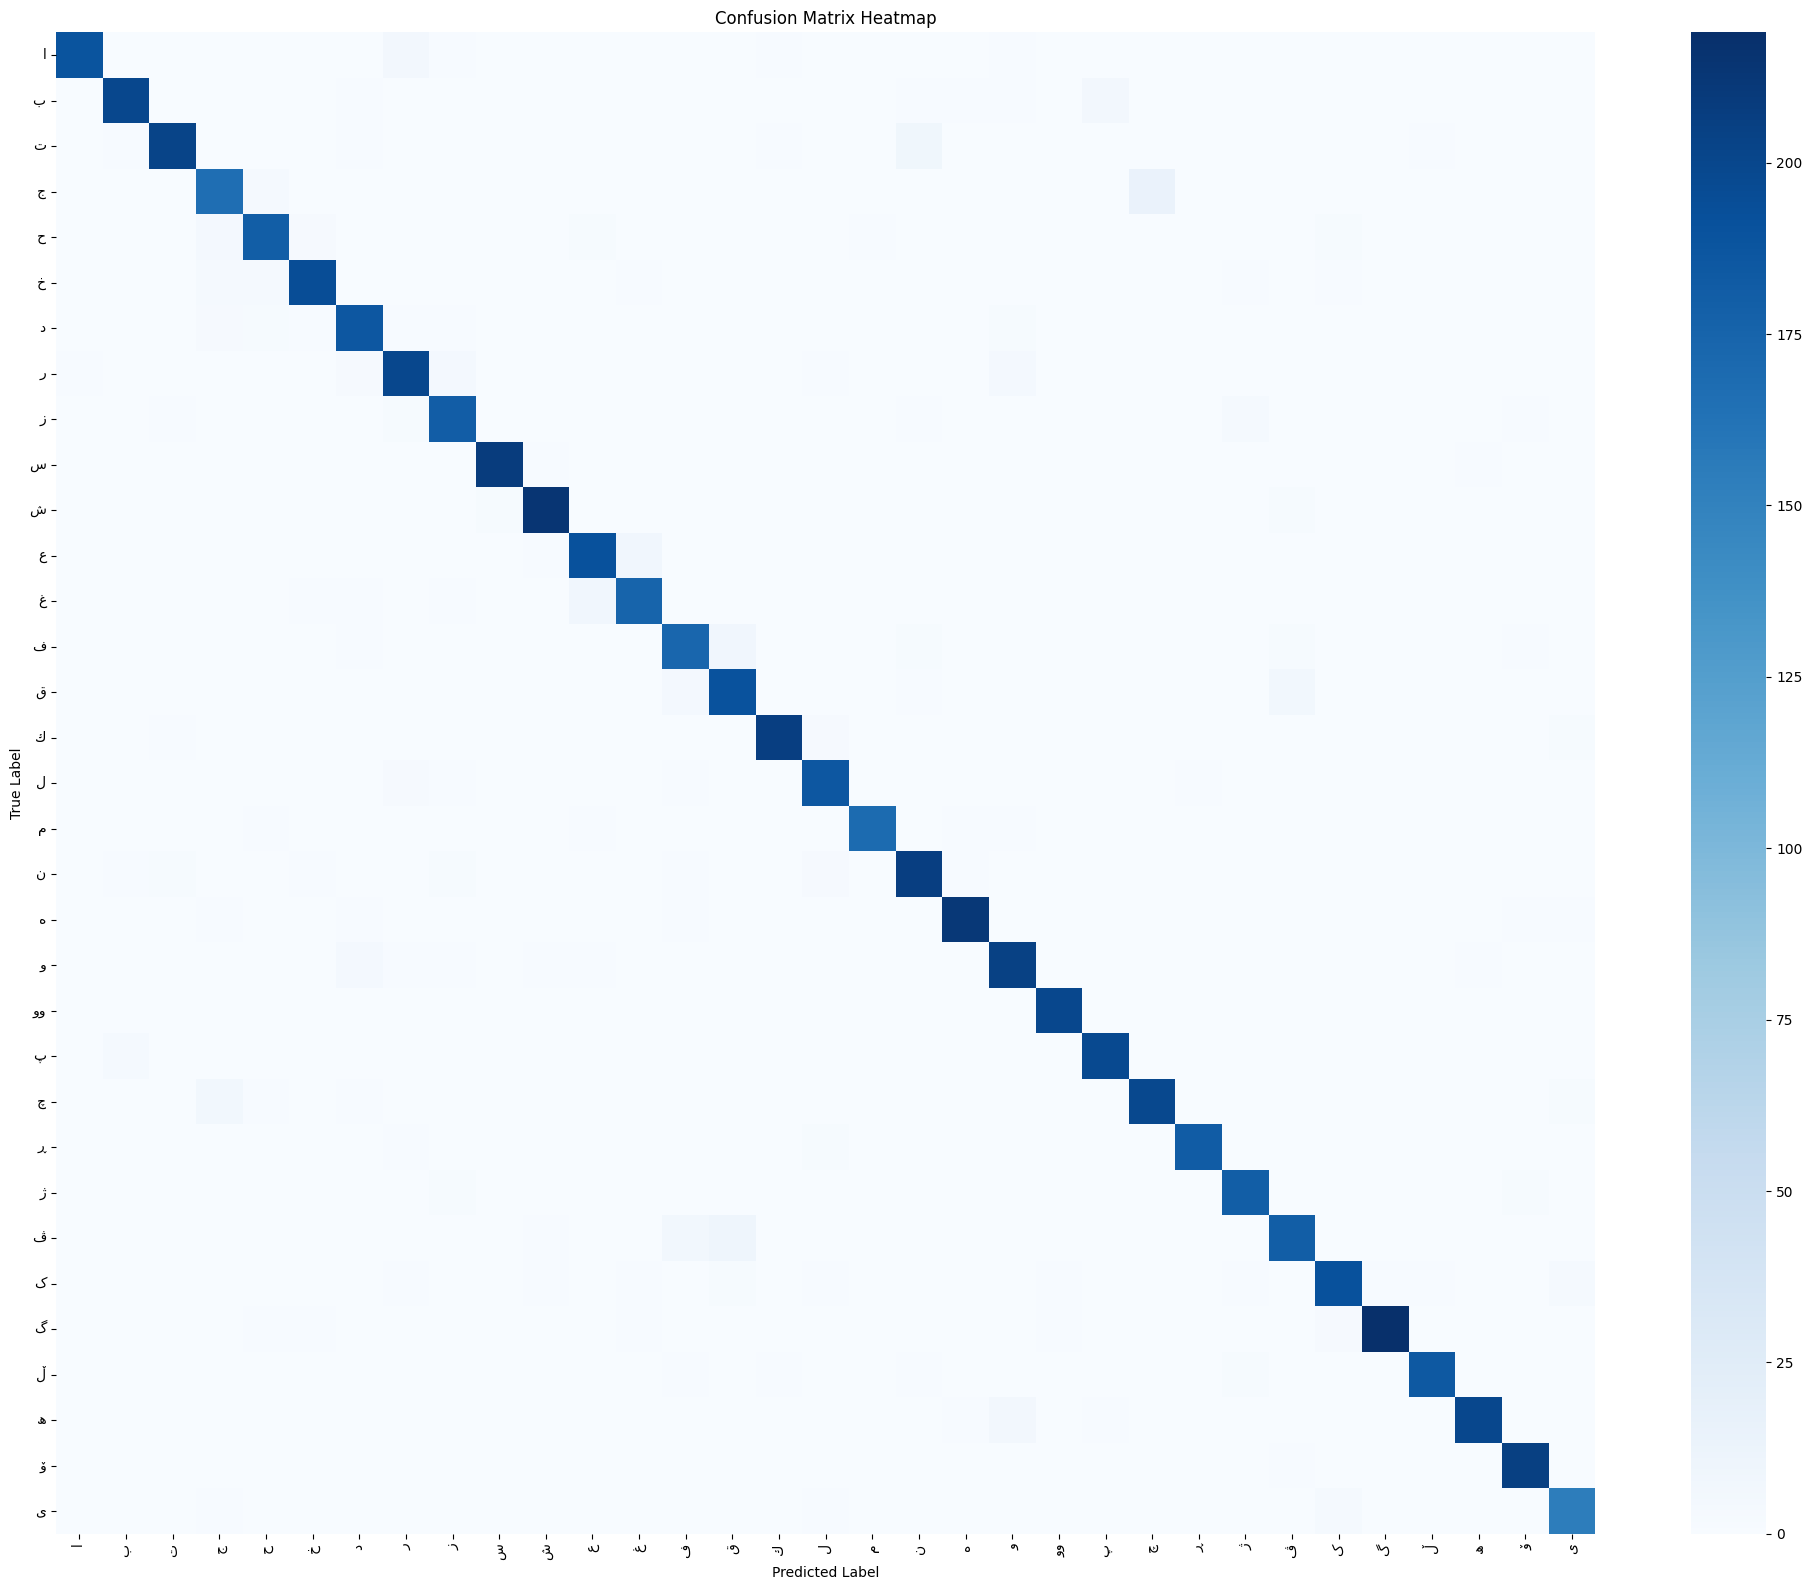


 Most Common Confusions (True -> Predicted):
   • 'ج'  mistaken for  'چ‎' : 15 times
   • 'ڤ'  mistaken for  'ق' : 10 times
   • 'ت'  mistaken for  'ن' : 9 times
   • 'ع'  mistaken for  'غ' : 8 times
   • 'غ'  mistaken for  'ع' : 8 times
   • 'ف'  mistaken for  'ق' : 8 times
   • 'ق'  mistaken for  'ڤ' : 7 times
   • 'چ‎'  mistaken for  'ج' : 7 times
   • 'ڤ'  mistaken for  'ف' : 7 times
   • 'ا‎'  mistaken for  'ر‎' : 6 times

 Gallery of Mistakes (High Confidence Errors):


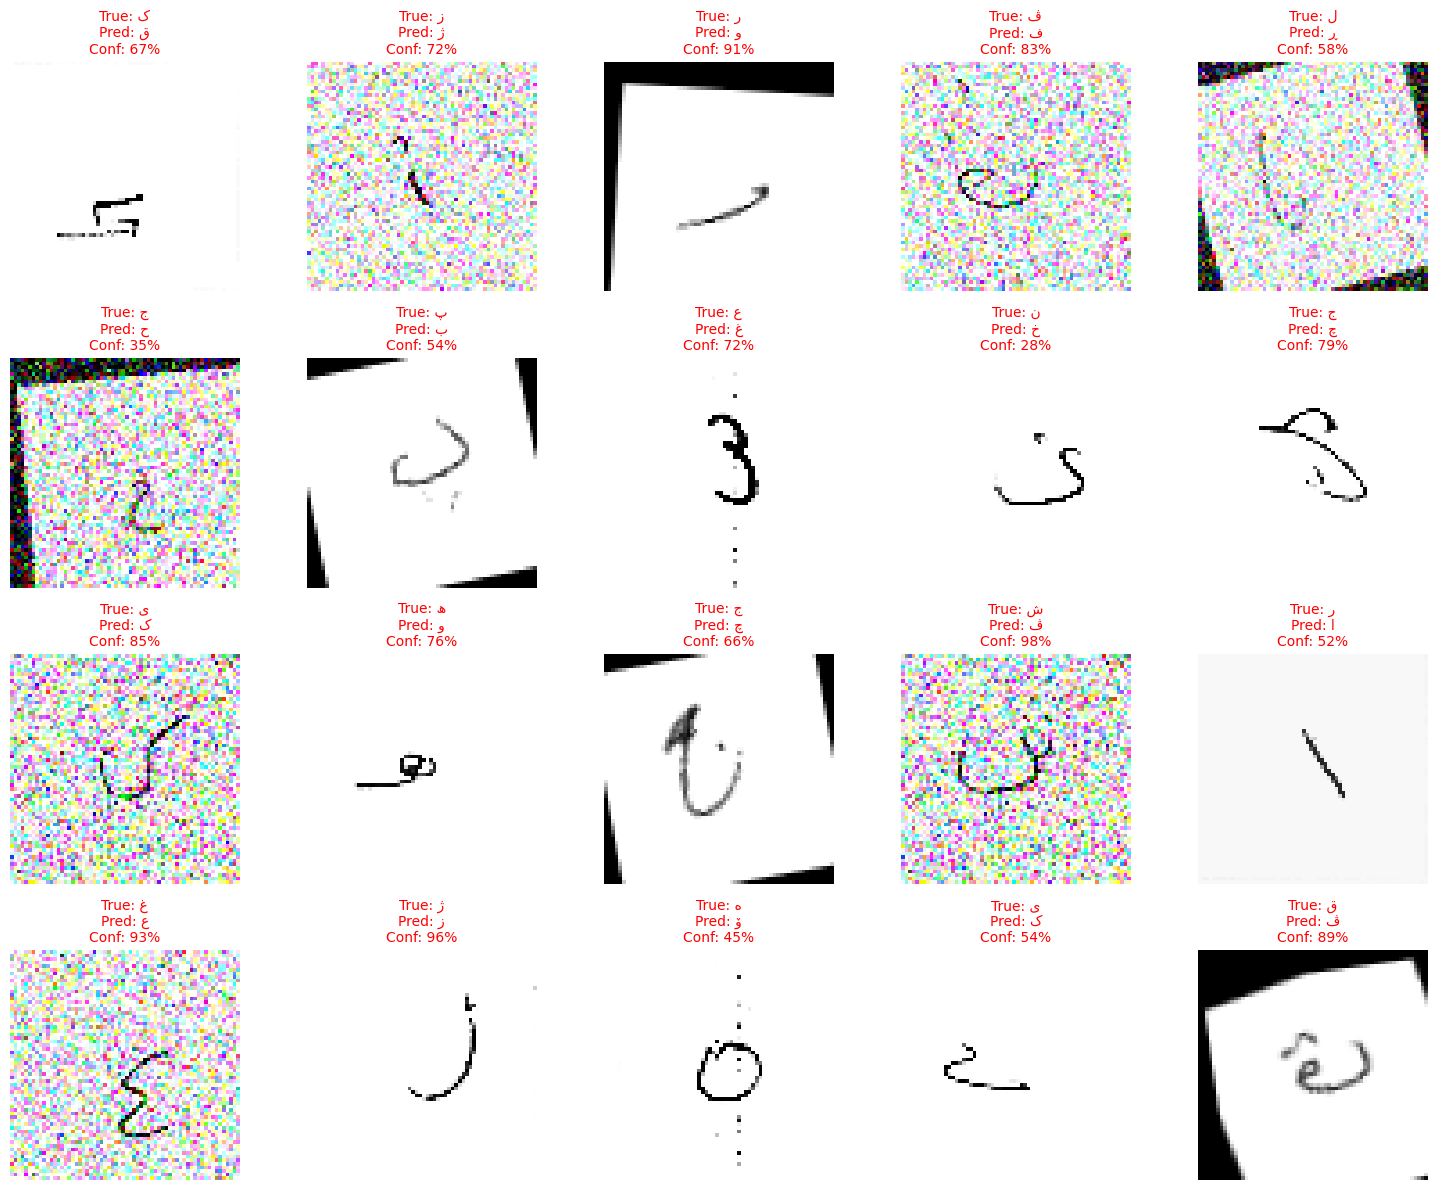

In [18]:
# 1. Initialize the model architecture first
num_classes = len(kurdish_dataset.label_encoder.classes_)
model = KurdishAdvancedCNN(num_classes=num_classes).to(device)

# 2. Load the saved weights
# ADD weights_only=False to allow loading the saved LabelEncoder
checkpoint = torch.load(MODEL_PATH, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

# 3. Pass the loaded MODEL object
evaluate_model_comprehensive(model, val_loader, device, kurdish_dataset.label_encoder)